In [1]:
import ingestor, modeller, fitter, viewer
import numpy as np
import matplotlib.pyplot as plt

In [138]:
from importlib import reload

reload(fitter)
reload(modeller)
reload(ingestor)
reload(viewer)

<module 'viewer' from '/media/dwu402/Data/self-harm/viewer.py'>

In [3]:
%matplotlib notebook
viewer.setup_canvas(size=[13.5, 9], ipy=True)

In [5]:
context = ingestor.Context("runs/passivefullall.run")

In [6]:
solver = fitter.Fitter(context)

In [8]:
RUNNING = False

rhos = np.logspace(-6, 8, num=57)

if not RUNNING:
    solver.read('out/passive_full_all.out')
elif RUNNING:
    for rhoi in rhos:
        solver.solve(rhoi, propagate=True)

# Validation

In [139]:
view = viewer.Plotter(context=context, fitter=solver)
labels = 'rabkpmscdfgjl????????????'

In [10]:
rho = 1000.0

<IPython.core.display.Javascript object>


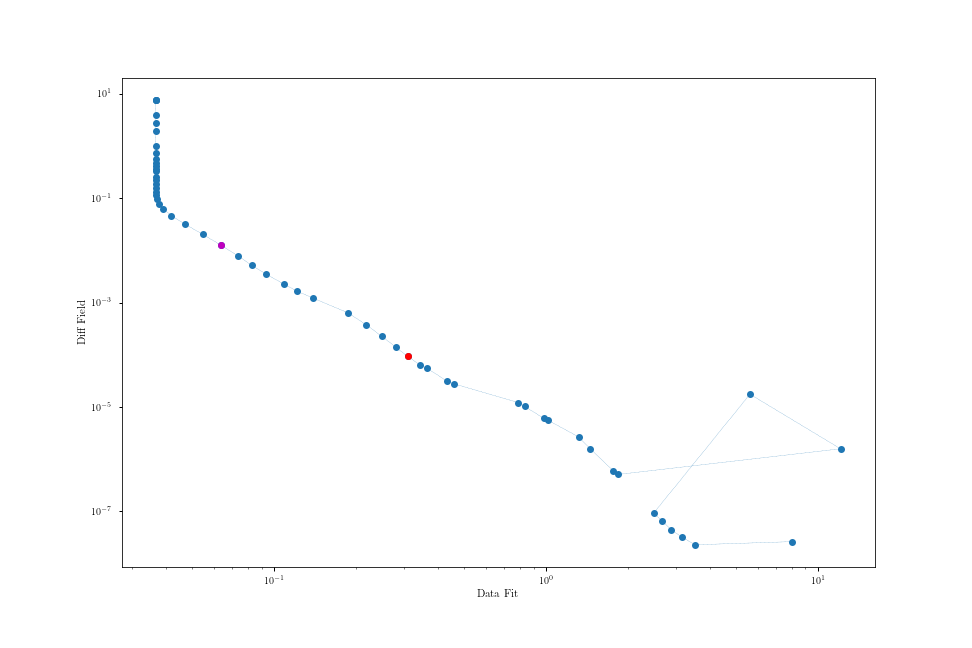

1.7782794100389228
 is the closest


In [11]:
rho = view.draw_lcurve(problem=0, target_rho=rho, optimal=True)

par r=1.4589248548043587
par a=0.8657022032367959
par b=0.5973548628592736
par k=11.337953811273048
par p=0.15165244977062373
par m=0.7229192068745909
par s=0.08484751281064389
par c=0.11946356208547397
par d=0.4692333994031925
par f=2.9658672115209423
par g=1.8178113355234053
par j=2.97324738413379
par l=19.382653013771844


<IPython.core.display.Javascript object>


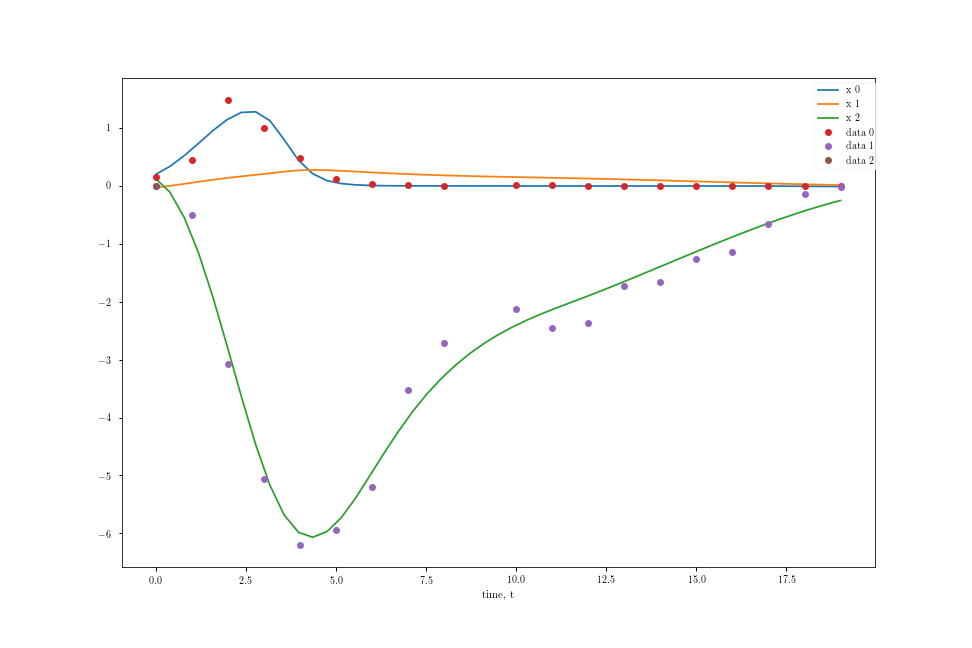

In [136]:
view.print_solution(target_rho=1e4, problem=0, labels=labels)
view.draw_solution(problem=0, target_rho=1e4, plane='t')

<IPython.core.display.Javascript object>


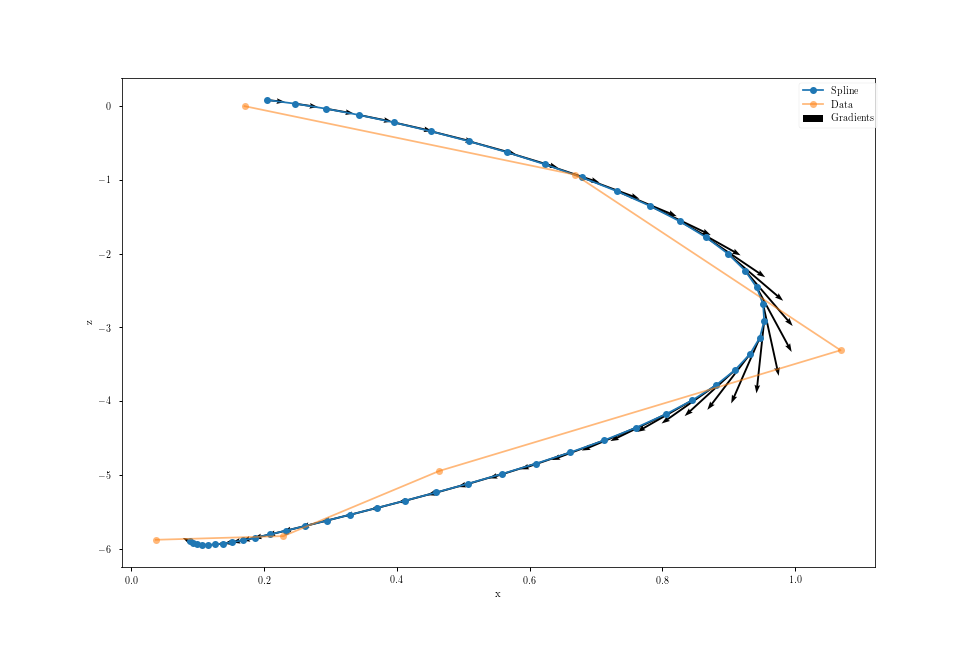

In [57]:
view.draw_solution(problem=1, target_rho=1e4, plane=[0,2], datakeys='xz')

<IPython.core.display.Javascript object>


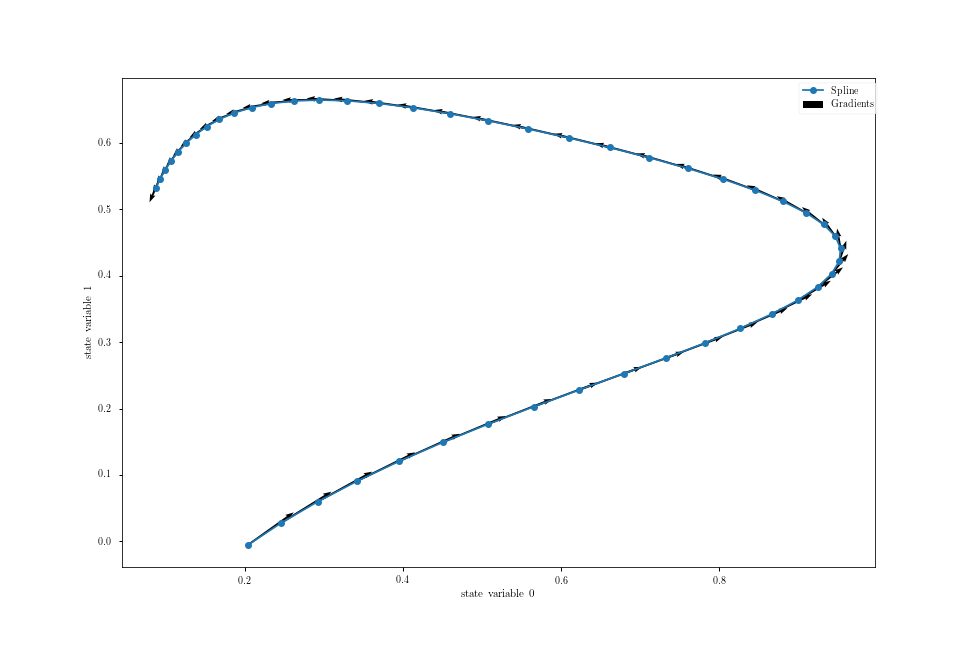

In [84]:
view.draw_solution(problem=1, target_rho=1e4, plane=[0,1])

## Diagnostics

<IPython.core.display.Javascript object>


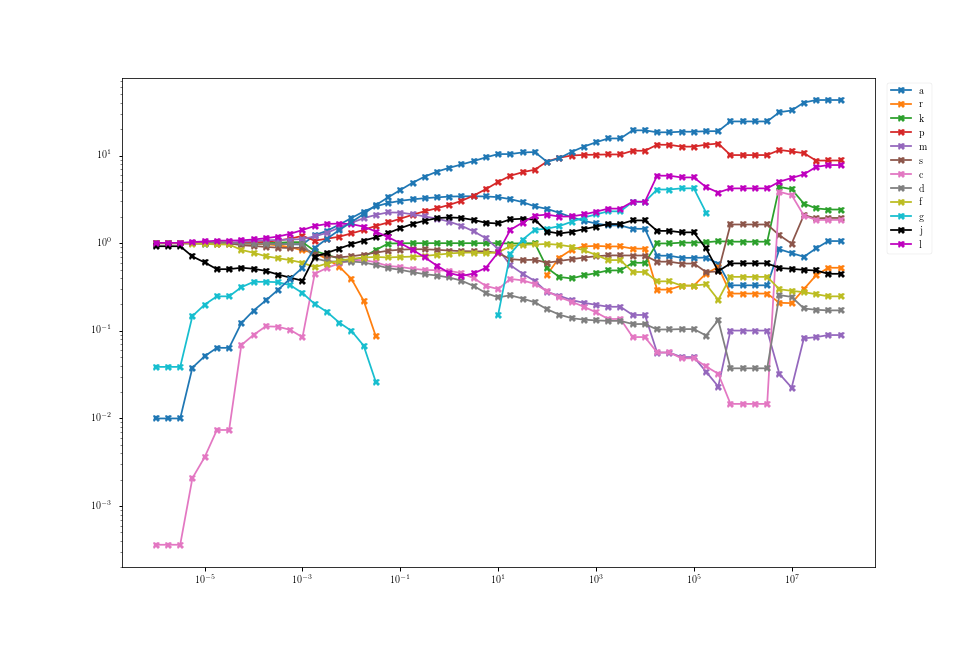

In [13]:
view.show_parameter_values(problem=0, labels=labels)

<IPython.core.display.Javascript object>


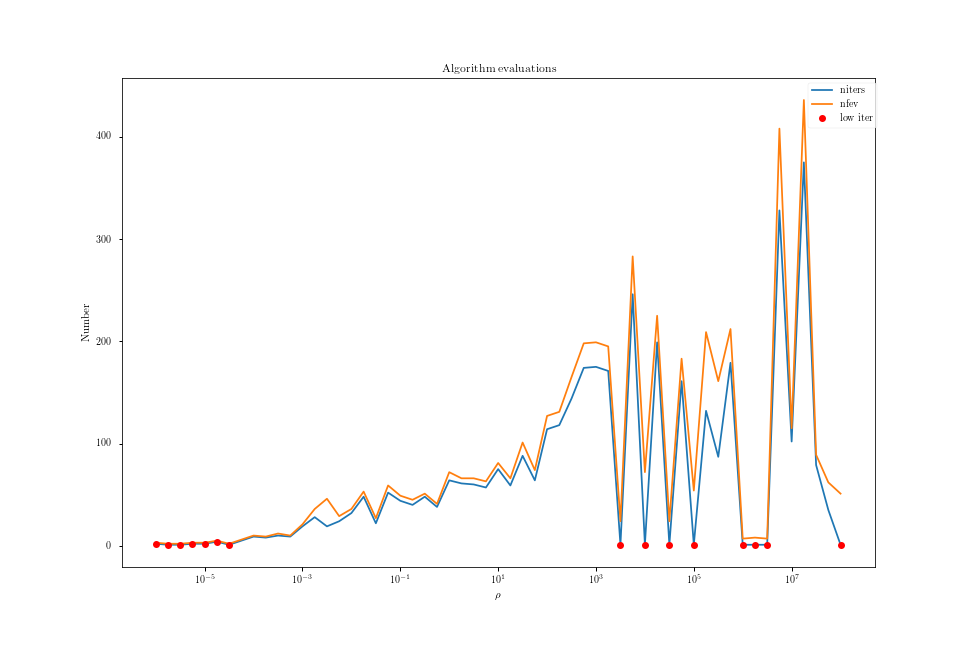

In [14]:
view.show_iterations(problem=0)

<IPython.core.display.Javascript object>


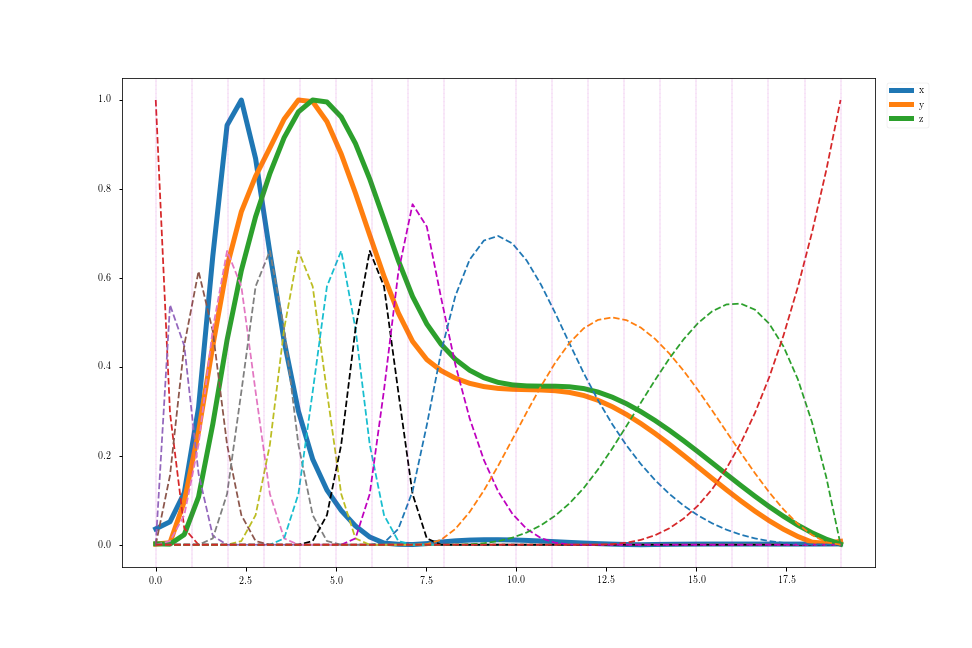

In [15]:
view.draw_basis(problem=0, target_rho=rho, labels='xyz')

## Smoothing Experiments

In [16]:
# from scipy import interpolate

# smooth_outer = interpolate.UnivariateSpline(np.log10(rhos), np.log10(datafit_values[:,1]), s=0.14)
# souter =  np.array([10**x for x in smooth_outer(np.log10(rhos))])
# plt.loglog(rhos, souter, rhos, datafit_values[:,1], 'o')
# plt.gca().xaxis.grid(True)

# smooth_dfield = interpolate.UnivariateSpline(np.log10(rhos), np.log10(dfield_direct[:,1]), s=0.2)
# sfield =  np.array([10**x for x in smooth_dfield(np.log10(rhos))])
# plt.loglog(rhos, sfield, rhos, dfield_direct[:,1], 'o')
# plt.gca().xaxis.grid(True)

# rhos_log_finer = np.linspace(np.log10(rhos[0]), np.log10(rhos[-1]), len(rhos)*5)
# sx = smooth_outer(rhos_log_finer)
# sy = smooth_dfield(rhos_log_finer)
# plottable_sx = 10**sx
# plottable_sy = 10**sy

# plt.plot(np.log10(datafit_values[:,1]), np.log10(dfield_direct[:,1]))
# ix = np.argmin(sx)
# iy = np.argmin(sy)
# plt.plot(sx[ix], sy[ix], 'ro', sx[iy], sy[iy], 'ko')

# fig = plt.figure()
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)
# ax1.plot(rhos_log_finer, sx)
# ax2.plot(rhos_log_finer, sy)
# ax1.set_ylabel("Data Fit")
# ax2.set_ylabel("Gradient Field Discrepancy")

# plt.loglog(plottable_sx, plottable_sy, '*--', datafit_values[:,1], dfield_direct[:,1], 'o--')
# plt.title("Smoothed vs Non-Smoothed L-Curve")
# plt.xlabel(r"Fit to Data $||y-{\Phi}c||$")
# plt.ylabel(r"Vector Field Discrepancy $||D({\Phi}c) - f({\Phi}c; \theta)||$")
# plt.legend(["Smoothed", "Non-Smoothed"])

# plt.loglog(plottable_sx[np.argmin(np.abs(rhos_log_finer - 0))],
#            plottable_sy[np.argmin(np.abs(rhos_log_finer - 0))],
#            'ro',
#            datafit_values[np.argmin(np.abs(np.array(rhos) - 1)), 1],
#            dfield_direct[np.argmin(np.abs(np.array(rhos) - 1)), 1], 
#            'ko')
# xlims = plt.xlim()
# ylims = plt.ylim()
# plt.loglog(np.linspace(10**(-15), 10**(4)), np.linspace(10**(-15), 10**(4)))
# plt.xlim(xlims); plt.ylim(ylims)

# # ? curvature
# f_dx = smooth_outer.derivative(1)
# f_dy = smooth_dfield.derivative(1)
# f_dx2 = smooth_outer.derivative(2)
# f_dy2 = smooth_dfield.derivative(2)

# scurv_dx = f_dx(rhos_log_finer)
# scurv_dy = f_dy(rhos_log_finer)
# scurv_dx2 = f_dx2(rhos_log_finer)
# scurv_dy2 = f_dy2(rhos_log_finer)

# kappa_fine = scurv_dx*scurv_dy2 - scurv_dy*scurv_dx2/(scurv_dx**2 + scurv_dy**2)**(3/2)

# plt.semilogy(rhos_log_finer, kappa_fine, 'o-')
# plt.title("L-Curve Curvature Plot")
# plt.xlabel(r"$\log_{10}(\rho)$")
# plt.ylabel(r"$\kappa$")

# # menger curvature
# curvs = []

# for idx in range(1, len(rhos_log_finer)-1):
#     xs = sx[idx-1:idx+2]
#     ys = sy[idx-1:idx+2]
#     ps = np.vstack([xs,ys]).T
#     curvs.append(2*np.abs(np.cross(ps[1] - ps[0], ps[2]-ps[1]))/(
#             np.linalg.norm(ps[0]-ps[1])*np.linalg.norm(ps[1]-ps[2])*np.linalg.norm(ps[2]-ps[0])))

# plt.semilogy(rhos_log_finer[1:-1], np.array(curvs), 'o-')
# plt.title("L-Curve Curvature Plot (via Menger Curvature)")
# plt.xlabel(r"$\log_{10}(\rho)$")
# plt.ylabel(r"$\kappa$")

# # implement the heuristic measurement
# origin  = (0,0)
# xy = np.array(list(zip(datafit_values[:,1], dfield_direct[:,1])))
# distances = [np.linalg.norm(xyi) for xyi in xy]
# plt.plot(np.log10(rhos), [1/d for d in distances])

# # implement a GM heuristic
# gmdistances = [2*np.sqrt(np.prod(xyi)) for xyi in xy]
# plt.plot(np.log10(rhos), [1/g for g in gmdistances])

# tot_heur = 1/np.sum([gmdistances,distances], axis=0)
# plt.plot(np.log10(rhos), tot_heur)

# observable_x = solver.inner_objectives[0].generate_collocation_matrix(context.datasets[0], solver.models[0])@xs_end[0]
# observable_z = solver.inner_objectives[0].generate_collocation_matrix(context.datasets[0], solver.models[0])@xs_end[2]

# x_err = np.abs(observable_x.T - np.array(context.datasets[0]['x'])).reshape(-1,)
# z_err = np.abs(observable_z.T - np.array(context.datasets[0]['z'])).reshape(-1,)

# t = np.array(context.datasets[0]['t'])

# plt.plot(t, x_err, t, z_err)
# print(f"{np.mean(x_err)} : {np.std(x_err)}")
# print(f"{np.mean(z_err)} : {np.std(z_err)}")


# x0, y0 = xs_end[[0,2], :]
# xscale = np.mean(x_err) + 1.96*np.std(x_err)
# zscale = np.mean(z_err) + 1.96*np.std(z_err)
# circle_x, circle_y = [x0 + xscale*np.cos(np.linspace(0, 2*np.pi, 50)), y0 + zscale*np.sin(np.linspace(0, 2*np.pi, 50))]

# plt.plot(xs_end[0], xs_end[2])
# plt.plot(context.datasets[0]['x'], context.datasets[0]['z'], 'o--', alpha=0.65)
# plt.plot(circle_x, circle_y, 'ko', alpha=0.2)
# print('')


# ## Use heuristic to estimate the "ideal" parameter
# # maximus = 10**rhos_log_finer[np.argmax(tot_heur)+1]
# # print(f"{maximus}\n is the spike")
# # closest_rho = rhos[np.argmin(np.abs(rhos-maximus))]
# # print(f"{closest_rho}\n is the closest")
# closest_rho = rhos[np.argmax(tot_heur)]
# print(f"{closest_rho}\n is the closest")

## Analysis

[3519.804987618675, 994.9741165472441, 2637.8837223669534, 107.48398419240034, 1749.309196484169, 87.8883098580113, 7183.570710393714, 2418.7303523524115, 478.81003864795747, 9477.336332596025, 188368.63455280644, 3519.804987618675, 478.81003864795747]


<IPython.core.display.Javascript object>


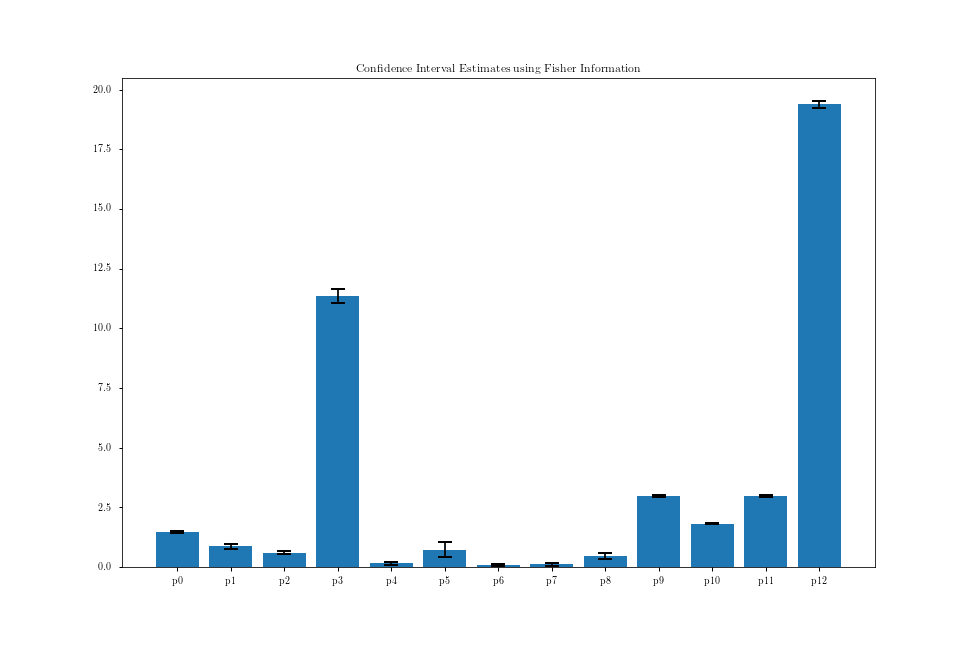

In [31]:
view.draw_confidence(problem=0, target_rho=1e4, verbose=True)

In [18]:
parameters = solver.solutions[str(rho)][0].x
print(-parameters[1]/parameters[0])

-0.0


/media/dwu402/Data/self-harm/viewer.py:283: RuntimeWarning: invalid value encountered in sqrt
  intervals = 3*np.sqrt(1/np.array(self.calculate_confidence(rho, problem)))
/media/dwu402/Data/self-harm/viewer.py:283: RuntimeWarning: divide by zero encountered in true_divide
  intervals = 3*np.sqrt(1/np.array(self.calculate_confidence(rho, problem)))


<IPython.core.display.Javascript object>


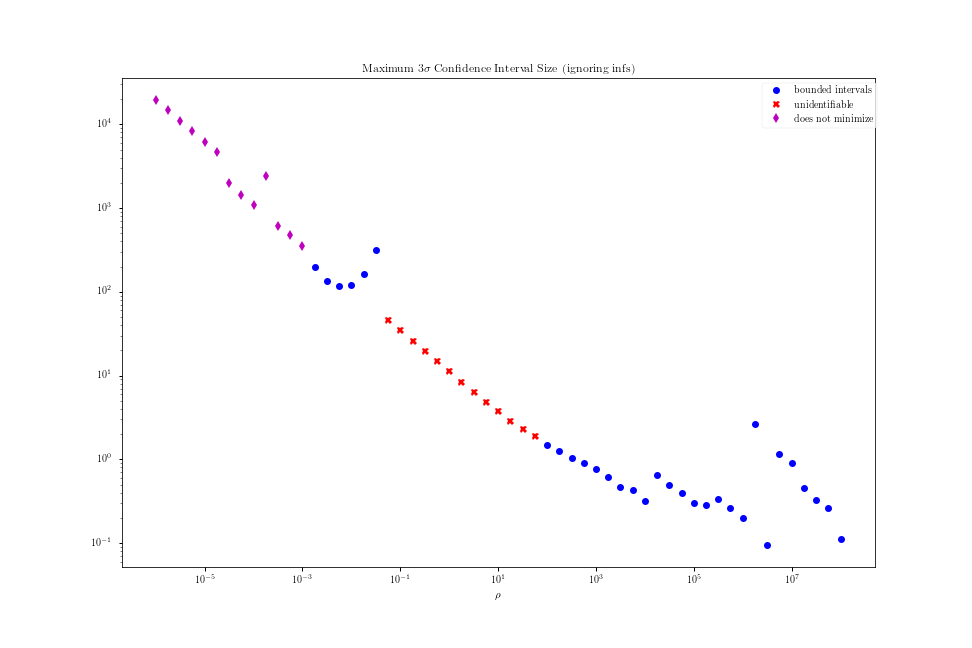

In [26]:
view.validate_on_confidence()

/media/dwu402/Data/self-harm/viewer.py:283: RuntimeWarning: divide by zero encountered in true_divide
  intervals = 3*np.sqrt(1/np.array(self.calculate_confidence(rho, problem)))
/media/dwu402/Data/self-harm/viewer.py:283: RuntimeWarning: invalid value encountered in sqrt
  intervals = 3*np.sqrt(1/np.array(self.calculate_confidence(rho, problem)))


<IPython.core.display.Javascript object>


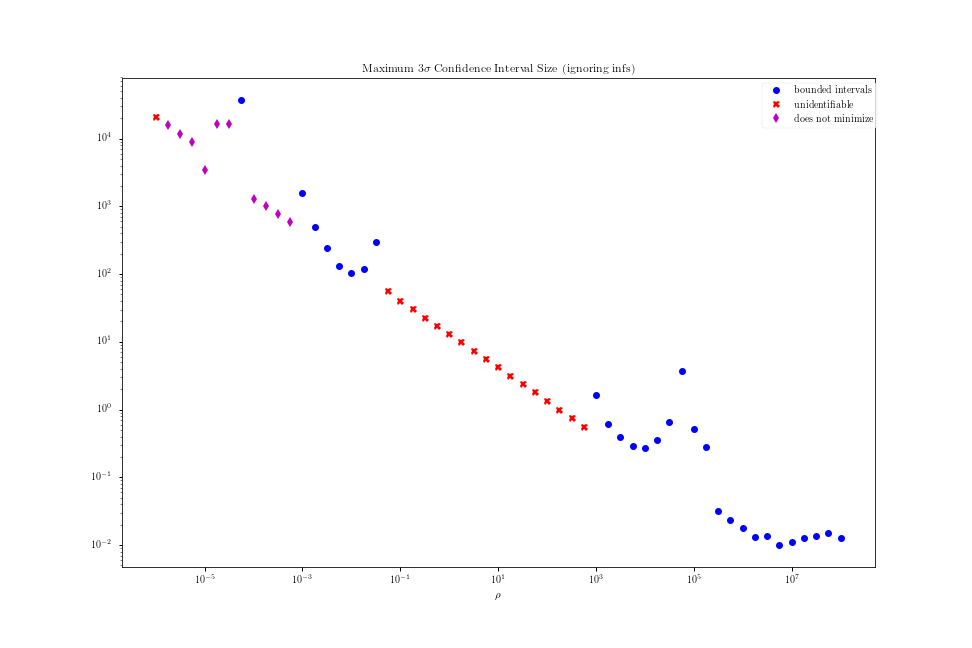

In [27]:
view.validate_on_confidence(problem=1)

In [19]:
# r,a,b,k,p,m,s,c,d,f,g,j,l = solver.solutions[str(target_rho)][0].x
# characteristic1 = np.roots([-d, s, 0, -d*c*c*c, 0])
# temp_alpha = (s*r*r*r)/(c*c*c*k*k*k+r*r*r) - d*r/k
# characteristic2 = np.roots([temp_alpha, p, m*m*temp_alpha])

# # these are the values of gamma and xi
# print(characteristic1)
# print(characteristic2)

# eq_values1 = l*characteristic1/(f*characteristic1 - g)
# eq_values2 = (j*k*characteristic2 + l*r)/(f*r-g*k)

# print(eq_values1)
# print(eq_values2)

# rk = r/k

# def is_stable(point):
#     x,y,z = point
#     G = f*y-g
#     A = r-k*y
#     B = -k*x
#     C = p/(m**2+x**2) - (2*p*x**2)/(m**2+x**2)**2
#     D = (3*s*y**2)/(c**3 + y**3) - d - (3*s*y**5)/(c**3 + y**3)**2
#     character = (G<0, (A+D)<0 , A*D-B*C>0)
#     if all(character):
#         if ((A+D)**2)/4 < (A*D-B*C):
#             return "z-xy-focus"
#         return "z-xy"
#     elif character[0:3:2] == (True, False):
#         return "z-saddle"
#     elif character == (False, True, True):
#         if ((A+D)**2)/4 < (A*D-B*C):
#             return "unstable-xy-focus"
#         return "unstable-xy"
#     elif character[0]:
#         if ((A+D)**2)/4 < (A*D-B*C):
#             return "z-unstable-focus"
#         return "z-unstable"
#     else:
#         if ((A+D)**2)/4 < (A*D-B*C):
#             return "unstable-unstable-focus"
#         return "unstable-unstable"

    
# stabilities1 = [is_stable([0, ch, eq]) for ch, eq in zip(characteristic1, eq_values1)]
# stabilities2 = [is_stable([ch, rk, eq]) for ch, eq in zip(characteristic2, eq_values2)]

# print(stabilities1)
# print(stabilities2)

# plt.plot([0]*len(eq_values1[np.isreal(eq_values1)]), eq_values1[np.isreal(eq_values1)], 'ro')
# plt.plot(characteristic2[np.isreal(eq_values2)], eq_values2[np.isreal(eq_values2)], 'ro')
# plt.xlabel('x')
# plt.ylabel('z')

# print(f*r/k-g)

# Utilities

In [20]:
solver.solutions

{'1e-06': [      fun: 0.036709127615731675
   hess_inv: <13x13 LbfgsInvHessProduct with dtype=float64>
        jac: array([-1.68606156e-11, -3.86690534e-12,  1.49968602e-11,  8.44288871e-12,
          1.45598534e-08, -5.95060457e-08, -1.43339789e-08, -6.33471390e-09,
          2.41701453e-10, -1.28149892e-07,  2.56335103e-07, -1.98386297e-08,
         -3.30124198e-08])
    message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
       nfev: 3
        nit: 2
     status: 0
    success: True
          x: array([9.98493512e-01, 9.99374314e-01, 1.00150554e+00, 1.00075375e+00,
         1.00023516e+00, 9.99405774e-01, 3.62054780e-04, 9.99967907e-01,
         9.98021020e-01, 3.87540053e-02, 9.22464845e-01, 1.00773380e+00,
         9.99564371e-03]),       fun: 2.041513596917721e-05
   hess_inv: <13x13 LbfgsInvHessProduct with dtype=float64>
        jac: array([-1.12317283e-10,  9.16576448e-12,  1.12454641e-10,  6.75178775e-11,
          9.47248335e-08, -2.96835312e-07, -2.33024729e-08,  1

In [23]:
[str(rho) for rho in rhos]

['1e-06',
 '1.778279410038923e-06',
 '3.162277660168379e-06',
 '5.623413251903491e-06',
 '1e-05',
 '1.778279410038923e-05',
 '3.1622776601683795e-05',
 '5.623413251903491e-05',
 '0.0001',
 '0.00017782794100389227',
 '0.00031622776601683794',
 '0.0005623413251903491',
 '0.001',
 '0.0017782794100389228',
 '0.0031622776601683794',
 '0.005623413251903491',
 '0.01',
 '0.01778279410038923',
 '0.03162277660168379',
 '0.05623413251903491',
 '0.1',
 '0.1778279410038923',
 '0.31622776601683794',
 '0.5623413251903491',
 '1.0',
 '1.7782794100389228',
 '3.1622776601683795',
 '5.623413251903491',
 '10.0',
 '17.78279410038923',
 '31.622776601683793',
 '56.23413251903491',
 '100.0',
 '177.82794100389228',
 '316.22776601683796',
 '562.341325190349',
 '1000.0',
 '1778.2794100389228',
 '3162.2776601683795',
 '5623.413251903491',
 '10000.0',
 '17782.794100389227',
 '31622.776601683792',
 '56234.13251903491',
 '100000.0',
 '177827.94100389228',
 '316227.7660168379',
 '562341.3251903491',
 '1000000.0',
 '17

In [33]:
WRITE=False
if WRITE:
    solver.write("out/passive_full_all.out")

<IPython.core.display.Javascript object>


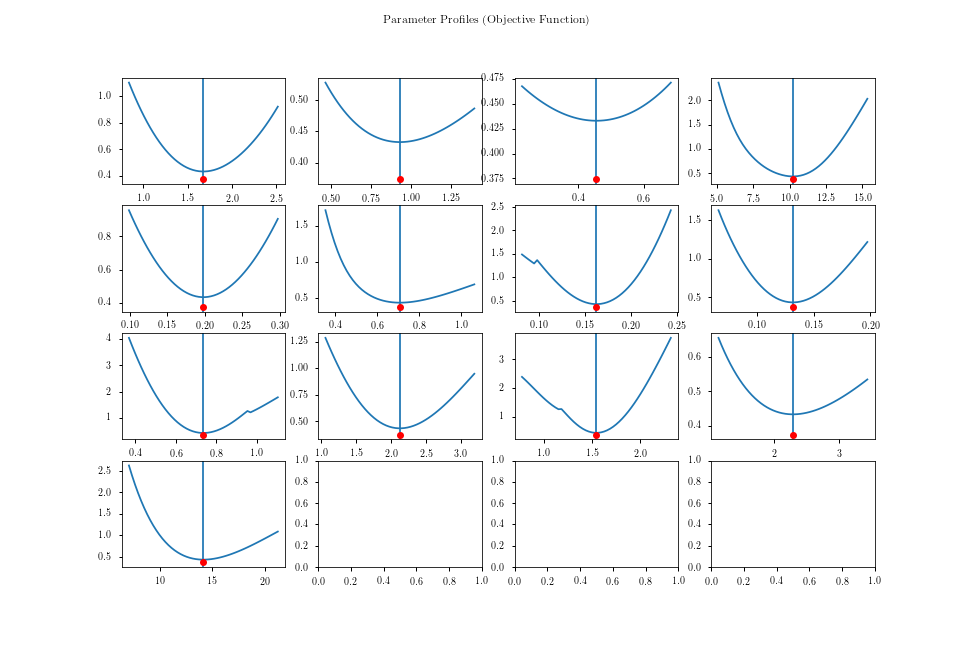

In [140]:
view.generate_all_slices(1e3, irange=1)

/home/dwu402/.virtualenvs/scider/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


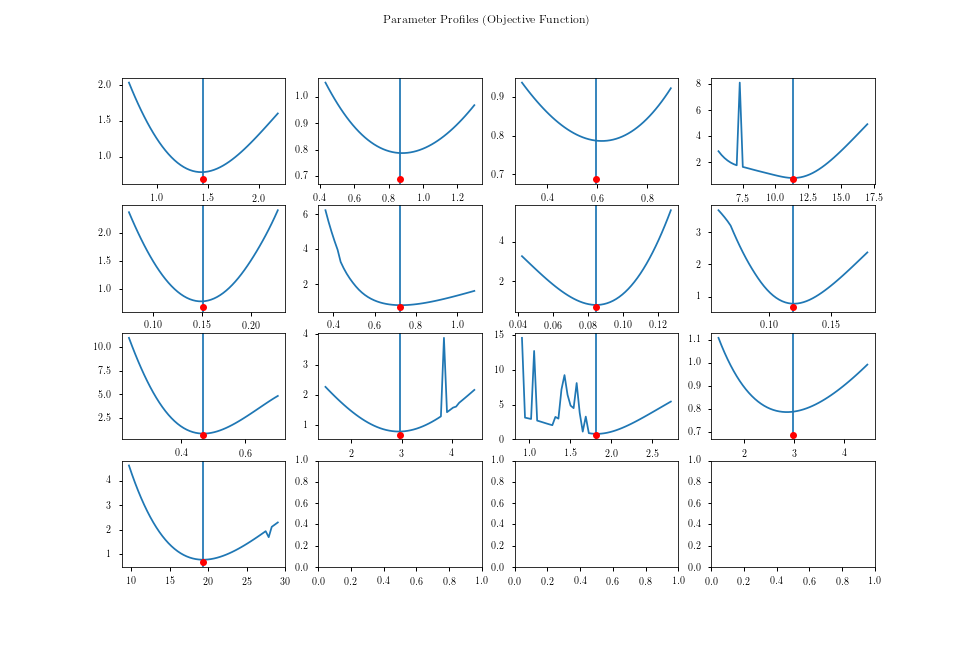

In [141]:
view.generate_all_slices(1e4, irange=1)

<IPython.core.display.Javascript object>


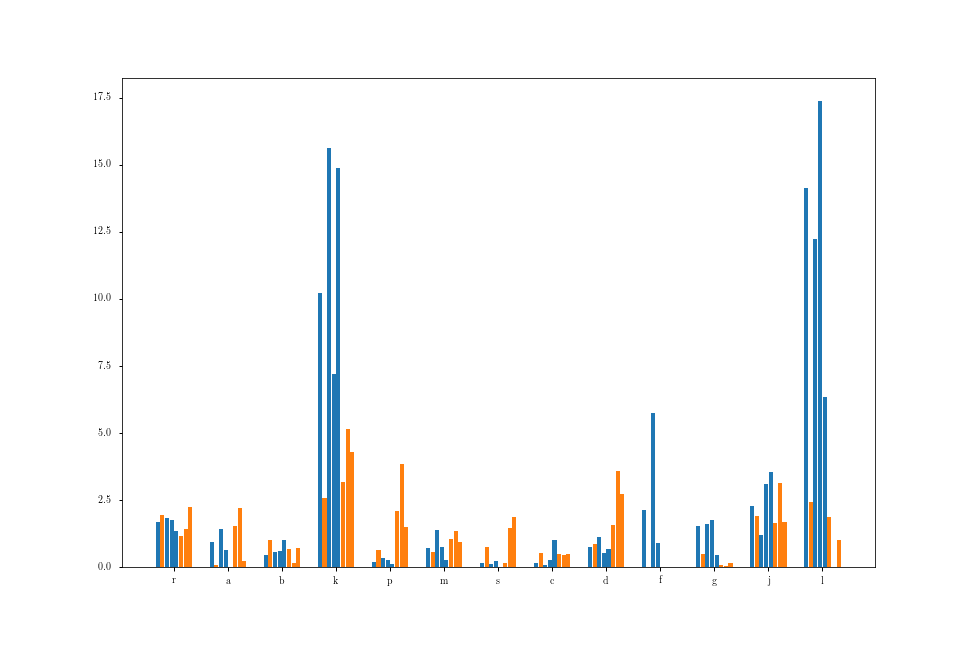

cycler('color', ['#1f77b4', '#ff7f0e', '#1f77b4', '#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e', '#ff7f0e'])


In [124]:
view.compare_parameters(1e3, categories=[0,1,0,0,0,1,1,1], labels=labels)

In [137]:
context.fitting_configuration['regularisation_value']

array([1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.])